In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import seaborn as sns
import sys
sys.path.append("../")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo
from util.util_functions import ClusteringExperiment

plt.rcParams['figure.figsize'] = [12, 8]
c = [
    "#007fff",
    "#ff3616",
    "#138d75",
    "#7d3c98",
    "#fbea6a",
]  # Blue, Red, Green, Purple, Yellow

sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=3.,
    palette=sns.color_palette("Set2")
)
CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 43
FONTSIZE = 48

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt

    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [2]:
blank_traces = np.load("./tunneling_conductances_pull.npz", allow_pickle=True)["arr_0"]
molecular_traces = np.load("./molecular_conductances_pull.npz", allow_pickle=True)["arr_0"]

In [3]:
pre_info = PreprocessInfo(
    high=-0.5,
    low=-5,
    plot_high=-.5,
    plot_low=-5,
    bins=100,
    bins_2d=(32, 32),
    hist2d_length=1024,
)

In [4]:
p_blanks, fullwindow_blanks = util_functions.rt_preprocessing(
    blank_traces[::2], pre_info, longest_cutoff=6_000, apply_log=True
)
p_molecular, fullwindow_molecular = util_functions.rt_preprocessing(
    molecular_traces, pre_info, longest_cutoff=6_000, apply_log=True
)

hist_blanks, hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)
hist_molecular, hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)

plot_hist_blanks, plot_hist_blanks2d = util_functions.get_histograms(
    fullwindow_blanks, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)
plot_hist_molecular, plot_hist_molecular2d = util_functions.get_histograms(
    fullwindow_molecular, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)

100%|██████████| 10150/10150 [00:04<00:00, 2100.76it/s]


Amount discarded: 363


100%|██████████| 20300/20300 [00:08<00:00, 2361.75it/s]


Amount discarded: 171


Generating 1D- and 2D histograms: 100%|██████████| 20129/20129 [00:06<00:00, 2972.12it/s]


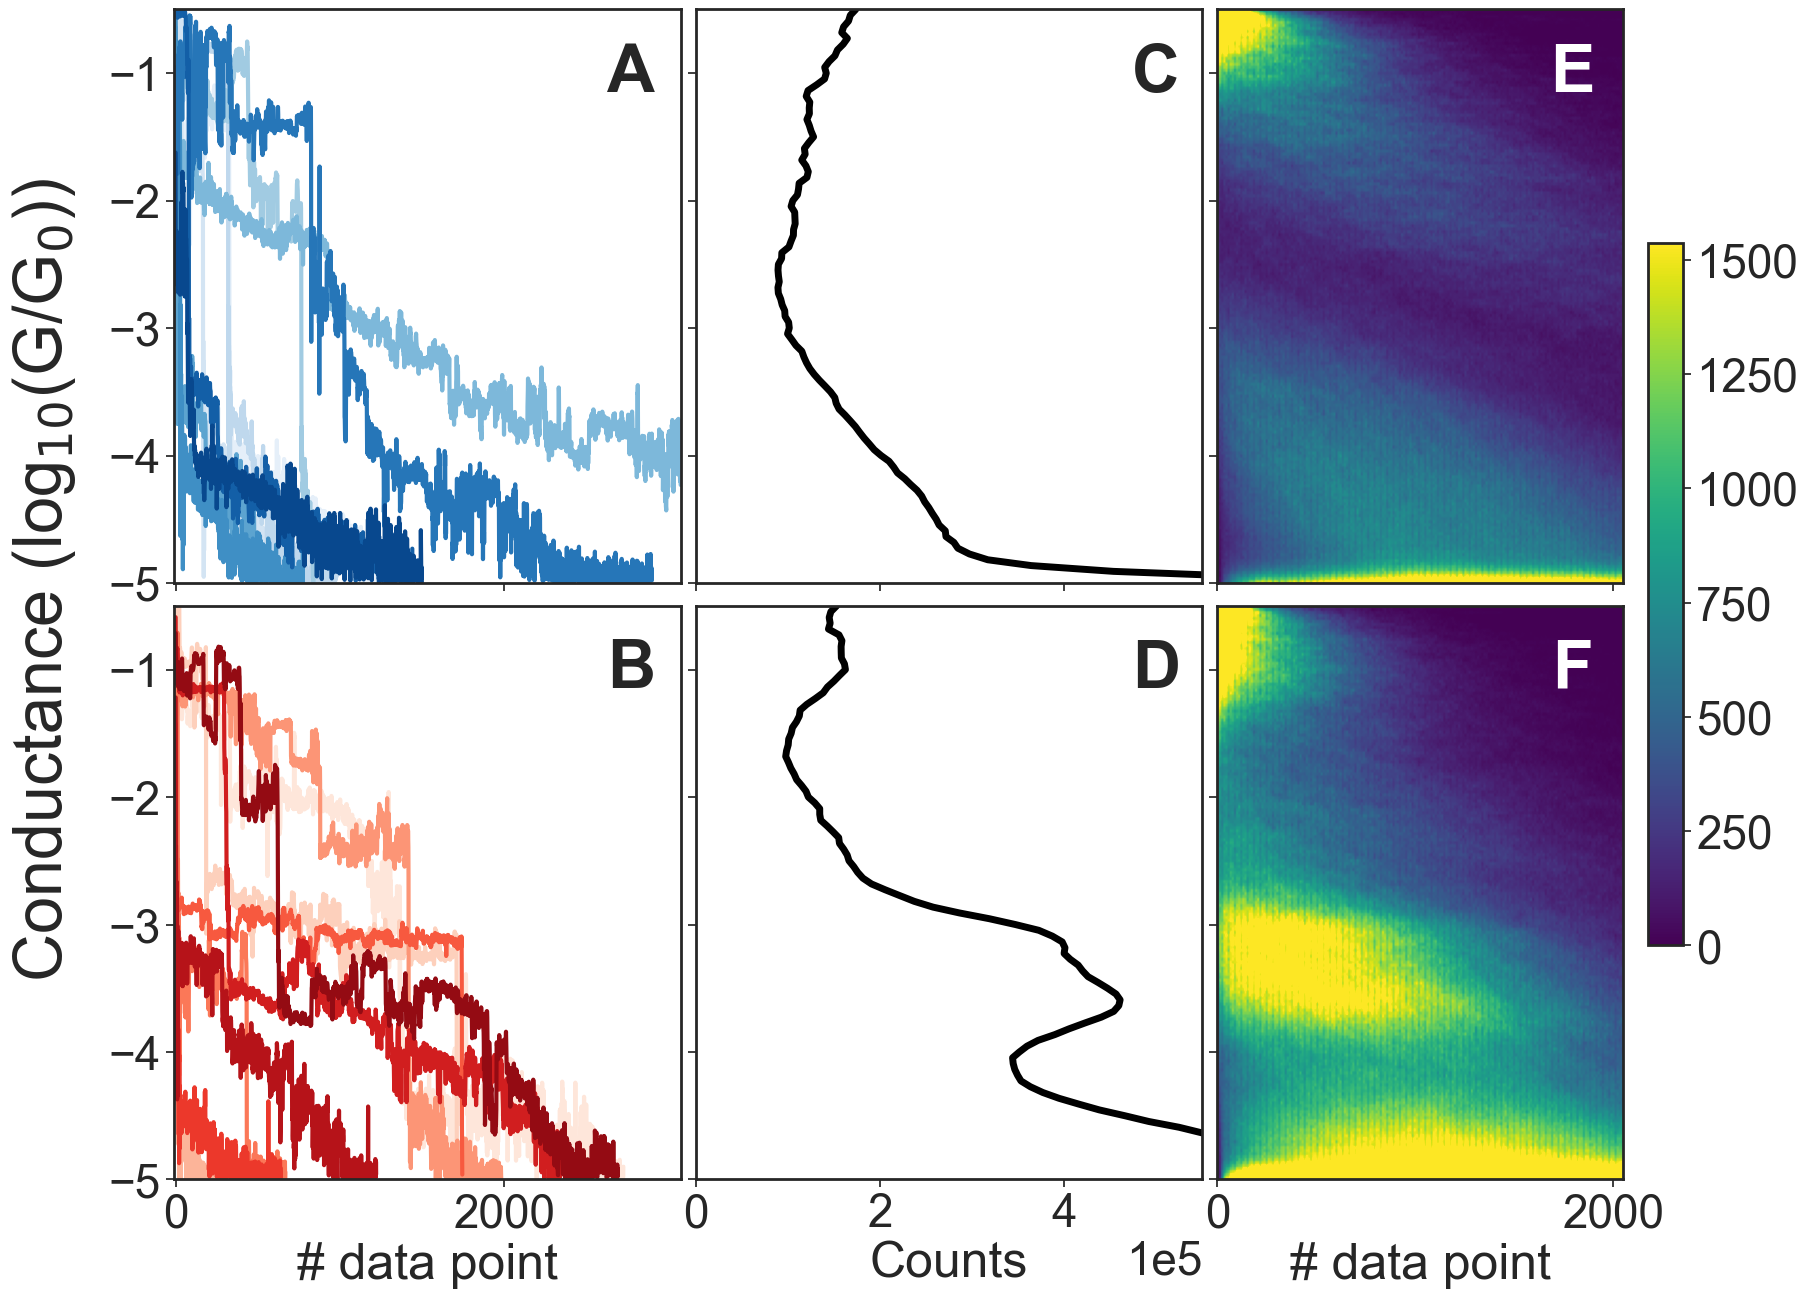

In [5]:
rng = np.random.default_rng(seed=RNG_STATE)
text_height = -1.
amount_traces = 10
blues = sns.color_palette("Blues", amount_traces)
reds = sns.color_palette("Reds", amount_traces)
colors = [blues, reds]

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [hist_blanks, fullwindow_blanks],
        [hist_molecular, fullwindow_molecular],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(low=0, high=len(dataset_traces), size=amount_traces, endpoint=True)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i], linewidth=3)
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, 2048 + 1024)
    ax[idx, 0].text(2048 + 1024 - 300, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    plot_hists = np.array(
        [np.histogram(trace, bins=pre_info.bins, range=(pre_info.plot_low, pre_info.plot_high))[0] for trace in dataset_traces]
    )
    ax[idx, 1].plot(
        plot_hists.sum(axis=0), np.linspace(pre_info.plot_low, pre_info.plot_high, plot_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 5.5e5)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(5e5, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in dataset_traces:
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, 2048]]
        )
        hist_2d += H

    im = ax[idx, 2].imshow(
        hist_2d, vmin=0, vmax=1024 + 512, origin="lower", cmap="viridis", extent=[0, 2048, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 2].text(
        2048 - 256, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )

    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.06, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.03, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("greta_hists.pdf")
plt.show()

In [6]:
features_blanks = hist_blanks2d
features_molecular = hist_molecular2d

# easy cleaning
# quick_labels = [1 if np.median(x) < -4.1 else -1 for x in p_blanks]
# feature_blanks = features_blanks[quick_labels == -1]
# features_blanks[features_blanks == 0] = 1e-4
# features_molecular[features_molecular == 0] = 1e-4
# the DL models can't handle 0's in the features due to sigmoid activation function

# features_blanks = np.concatenate((hist_blanks2d, ef_blanks), axis=1)
# features_molecular = np.concatenate((hist_molecular2d, ef_molecular), axis=1)
# features_blanks = ef_blanks
# features_molecular = ef_molecular


# remove zero columns
# idx = np.argwhere(np.all(features_blanks[..., :] < 6, axis=0))

# a2 = np.delete(features_blanks, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_blanks)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")

# features_blanks = a2

# a2 = np.delete(features_molecular, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_molecular)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")
# features_molecular = a2

In [7]:
from sklearn.svm import OneClassSVM
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE

model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.004)
model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01)
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)
model_gmm_9comp = GMMOutlierDetector(n_components=9, threshold=0.99, random_state=RNG_STATE)
model_gmm_12comp = GMMOutlierDetector(n_components=12, threshold=0.99, random_state=RNG_STATE)
model_gmm_20comp = GMMOutlierDetector(n_components=20, threshold=0.99, random_state=RNG_STATE)

# deep learning models
# epochs = 24
# contamination = 0.01
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=contamination, random_state=RNG_STATE)
# model_deepsvdd_ae = DeepSVDD(
#     use_ae=True,
#     epochs=epochs,
#     # hidden_neurons=[512, 512, 256],
#     hidden_activation="relu",
#     contamination=contamination,
#     optimizer="adam",
#     random_state=RNG_STATE,
# )
# model_deepsvdd_noae = DeepSVDD(
#     use_ae=False,
#     epochs=epochs,
#     # hidden_neurons=[512, 512, 256],
#     hidden_activation="relu",
#     contamination=contamination,
#     random_state=RNG_STATE,
# )
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=contamination, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    model_gmm_3comp,
    model_gmm_9comp,
    model_gmm_12comp,
    model_gmm_20comp,

    # model_simple_ae,
    # model_deepsvdd_ae,
    # model_deepsvdd_noae,
    # model_vae,
]

The following code block might take a long time to run, so we have provided labels from our latest production run instead.

In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_blanks = scaler.fit_transform(features_blanks)
# scaled_molecular = scaler.transform(features_molecular)
# predicted_labels = []
# for model in tqdm(models):
#     model = model.fit(scaled_blanks)

#     pred_labels = model.predict(scaled_molecular)
#     predicted_labels.append(pred_labels)

In [9]:
predicted_labels = np.load("./traditional_oc_labels_halftunneling.npy")

Amount predicted blanks: 6451


Generating 2D histograms: 100%|██████████| 6451/6451 [00:02<00:00, 3191.12it/s]


Amount predicted blanks: 6527


Generating 2D histograms: 100%|██████████| 6527/6527 [00:01<00:00, 3502.80it/s]


Amount predicted blanks: 17140


Generating 2D histograms: 100%|██████████| 17140/17140 [00:05<00:00, 3350.06it/s]


Amount predicted blanks: 7040


Generating 2D histograms: 100%|██████████| 7040/7040 [00:02<00:00, 2971.99it/s]


Amount predicted blanks: 5892


Generating 2D histograms: 100%|██████████| 5892/5892 [00:01<00:00, 3394.01it/s]


Amount predicted blanks: 5727


Generating 2D histograms: 100%|██████████| 5727/5727 [00:01<00:00, 3342.53it/s]


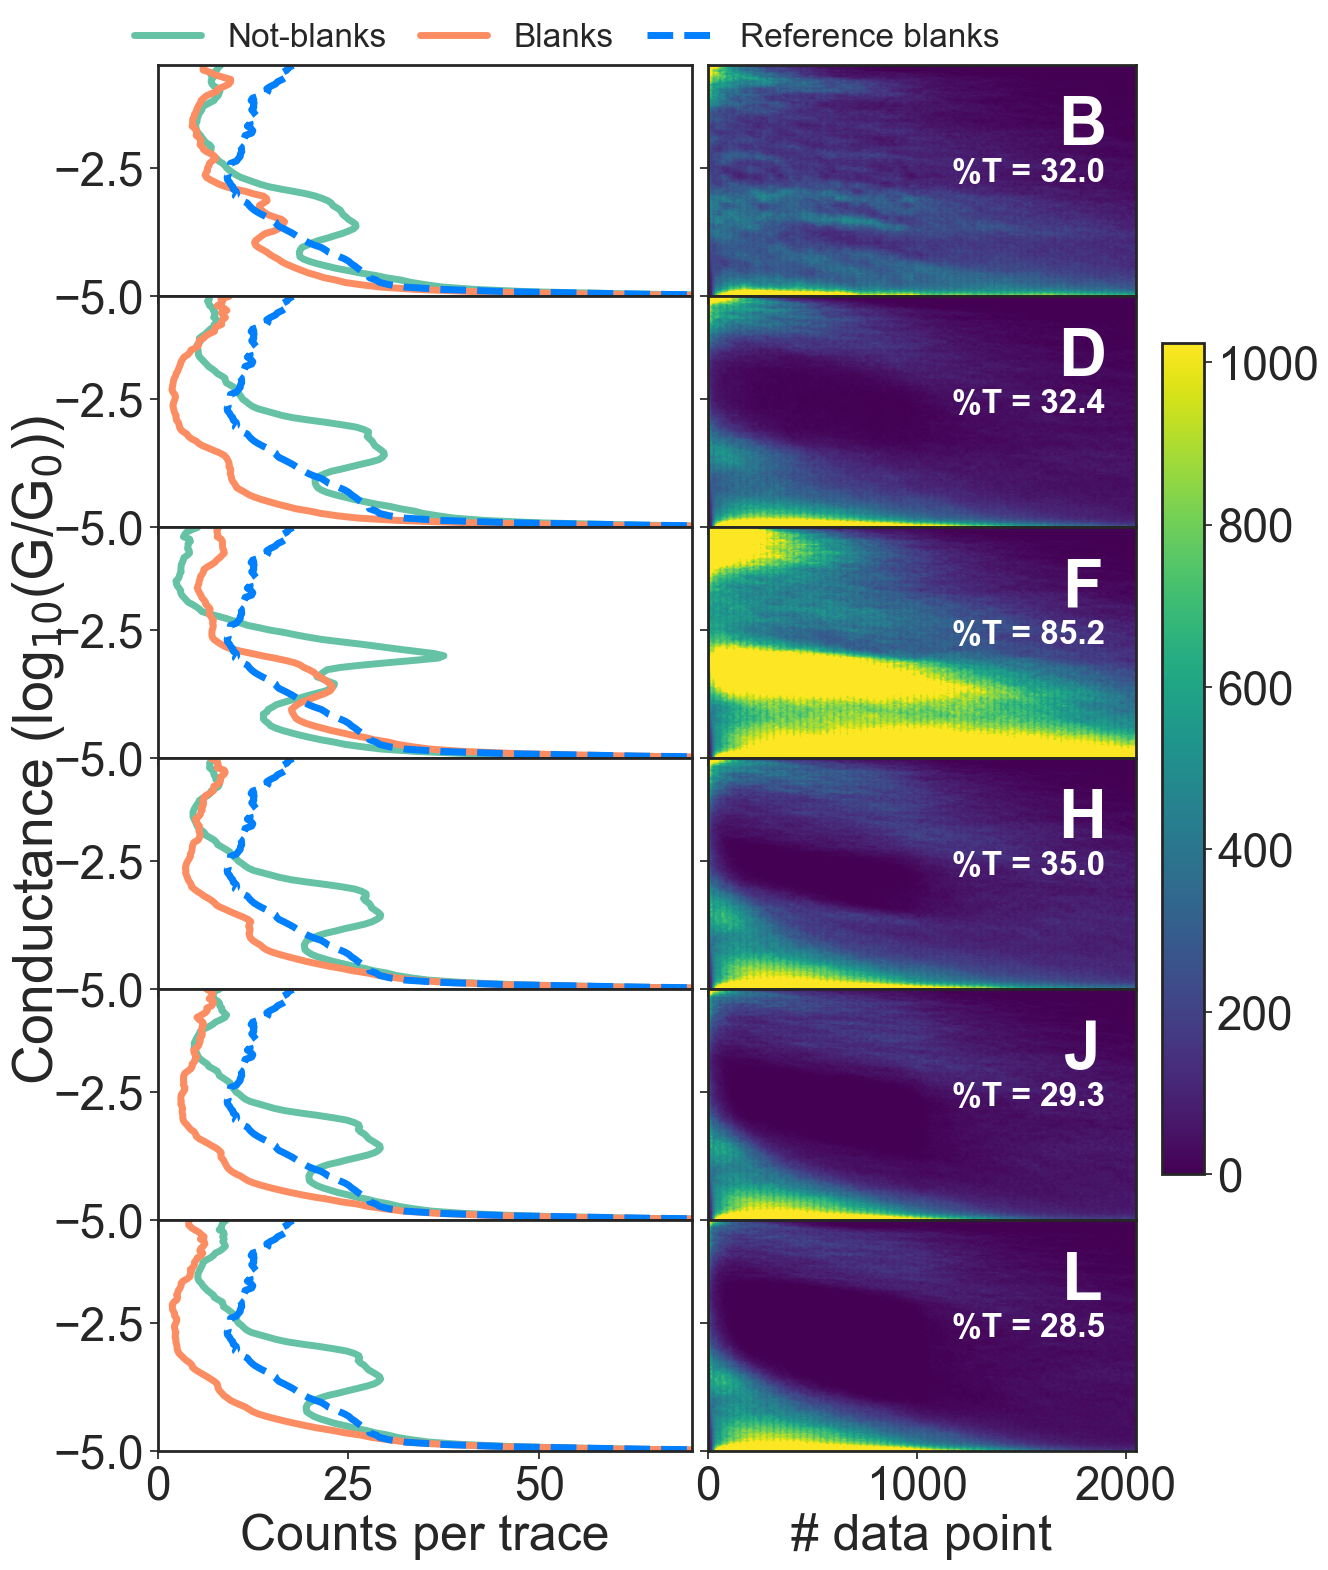

In [10]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26

ax1_yaxis = np.linspace(pre_info.low, pre_info.high, pre_info.bins)
max_ax1 = 0
percentages = []
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    pred_tun = hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    print(f"Amount predicted blanks: {len(pred_tun)}")
    percentages.append(1.0 - (len(hist_molecular) - len(pred_tun))/len(hist_molecular))

    ax[idx, 0].plot(
        hist_blanks.sum(axis=0)/len(hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "_",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.low, pre_info.high], [0, 2048]]
        )
        hist_2d += H

    im = ax[idx, 1].imshow(
        hist_2d,
        vmin=0,
        vmax=1024,
        origin="lower",
        cmap="viridis",
        extent=[0, 2048, pre_info.low, pre_info.high],
        aspect="auto",
    )

    if np.max(pred_mol.sum(axis=0)/len(pred_mol)) > max_ax1:
        max_ax1 = np.max(pred_mol.sum(axis=0)/len(pred_mol))
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.low, pre_info.high)

text_height = -1.7
for idx, p in enumerate(percentages):
    ax[idx, 0].text(max_ax1 - max_ax1*0.0, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(
        1024 + 512 + 256, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    ax[idx, 1].text(1024 + 512, text_height - .9, f"%T = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")

    ax[idx, 0].set_xlim(0, max_ax1 + max_ax1*0.15)
    ax[idx, 0].set_xlim(0, 70)
    if idx == 0:
        ax[idx, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(-0.1, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE // 2)

ax[-1, 0].set_xlabel("Counts per trace")
ax[-1, 1].set_xlabel("# data point")
fig.text(0.04, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical")
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./greta_visual_perf.pdf")
plt.show()

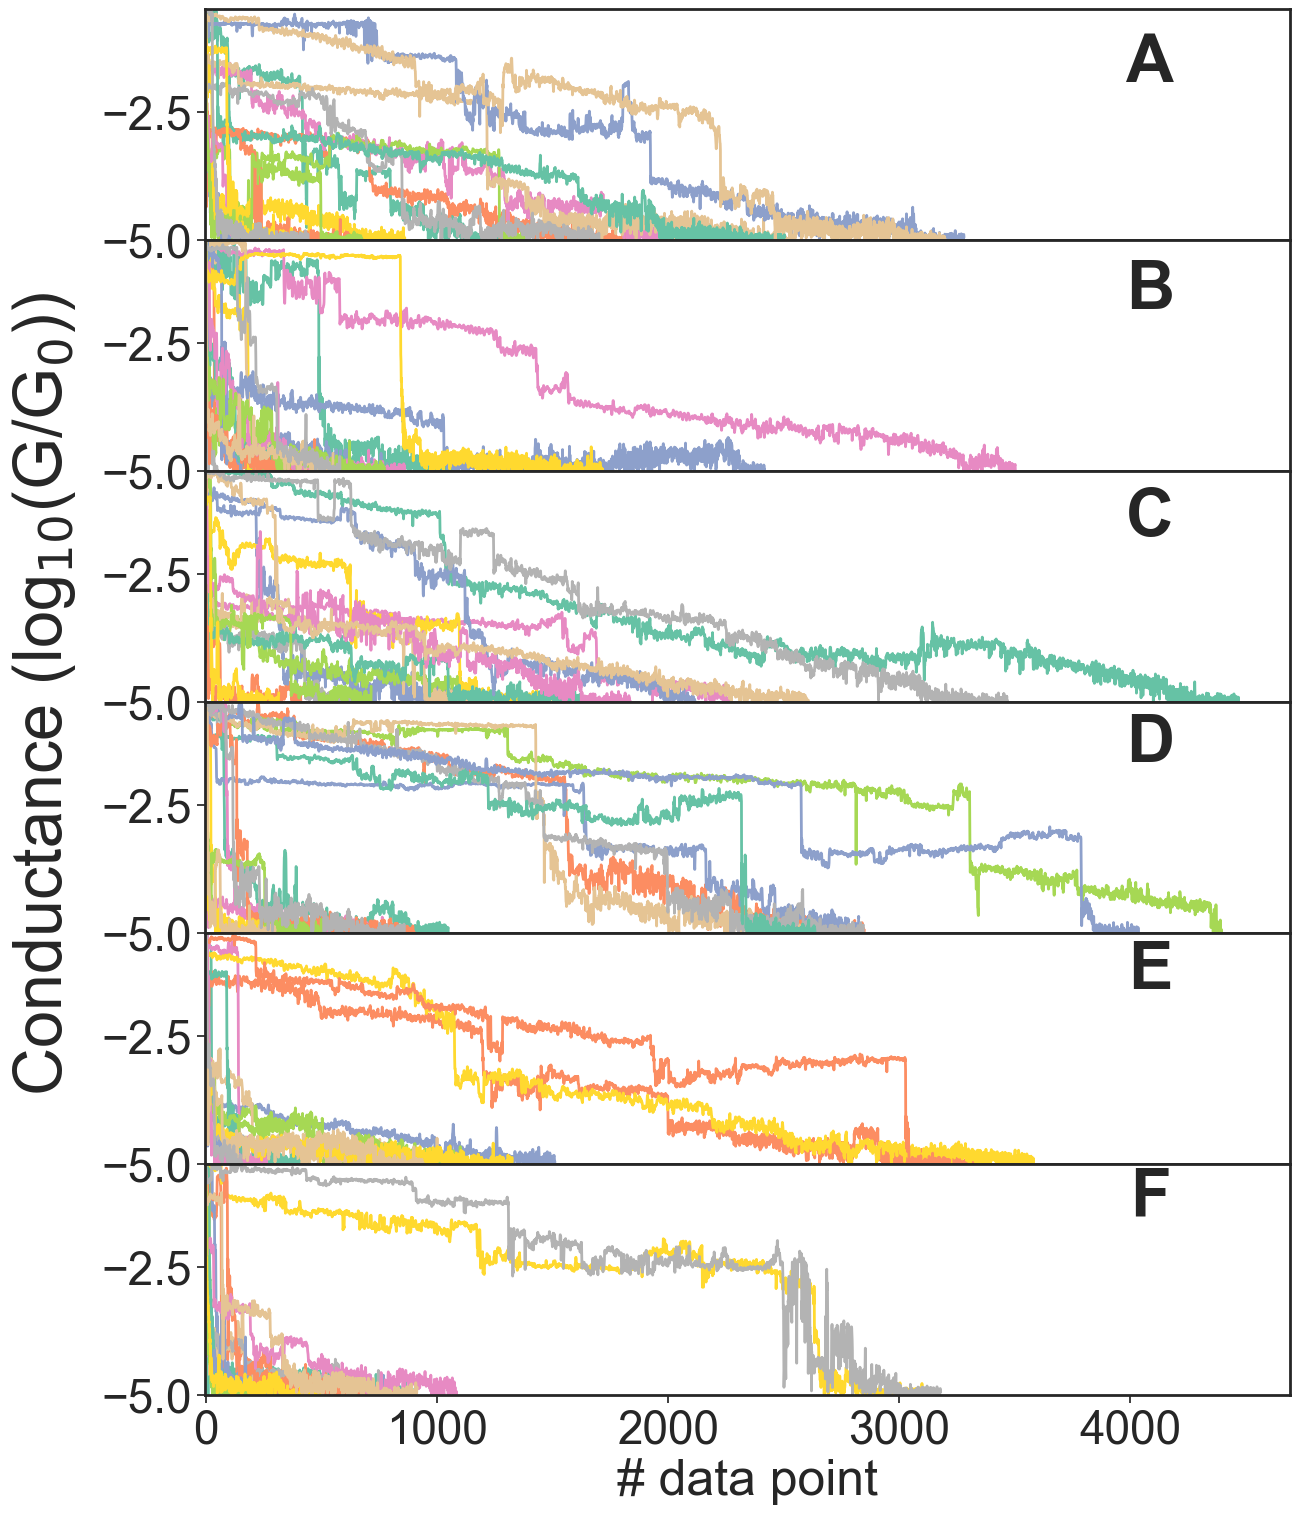

In [11]:
cm_blues = plt.get_cmap("Blues")
cm_reds = plt.get_cmap("Reds")

bins_2d = 64
x, y = np.meshgrid(np.arange(0, bins_2d), np.arange(0, bins_2d))
fig, axes = plt.subplots(len(models), 1, figsize=(14, 18), sharex=True, sharey=True)
for idx, (ax, label_set) in enumerate(zip(axes, predicted_labels)):
    util_functions.plot_individual_traces(p_molecular[label_set == 1], ax, size=16, rng=rng, lw=2)
    fig.text(0.8, .85 - idx*.126, ALPHABET[idx], weight="bold", size=FONTSIZE, va="center", ha="center")

plt.subplots_adjust(hspace=0.0)
plt.xlim(-4)
plt.ylim(pre_info.plot_low, pre_info.plot_high)
axes[-1].set_xlabel("# data point")
fig.text(0.01, 0.5, CONDUCTANCE_LABEL, ha="center", va="center", rotation="vertical", fontsize=FONTSIZE)
plt.savefig("predicted_tunneling_visualized.pdf")
plt.show()

  0%|          | 0/9787 [00:00<?, ?it/s]

100%|██████████| 13678/13678 [00:03<00:00, 3778.46it/s]


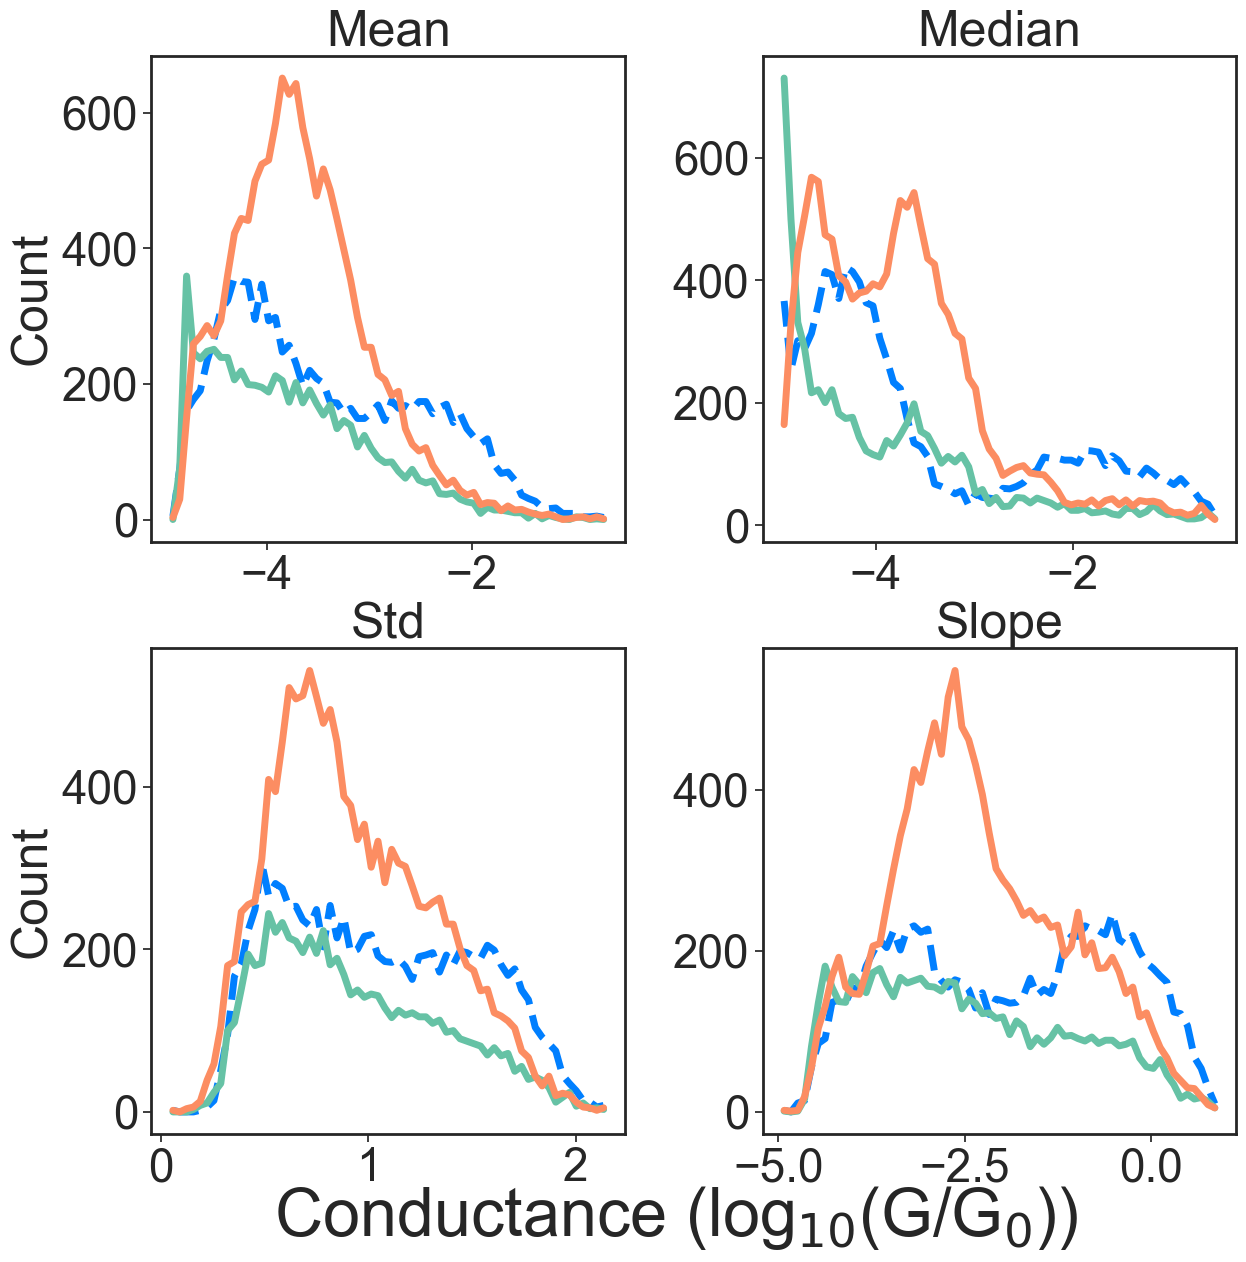

100%|██████████| 13602/13602 [00:03<00:00, 3412.93it/s]


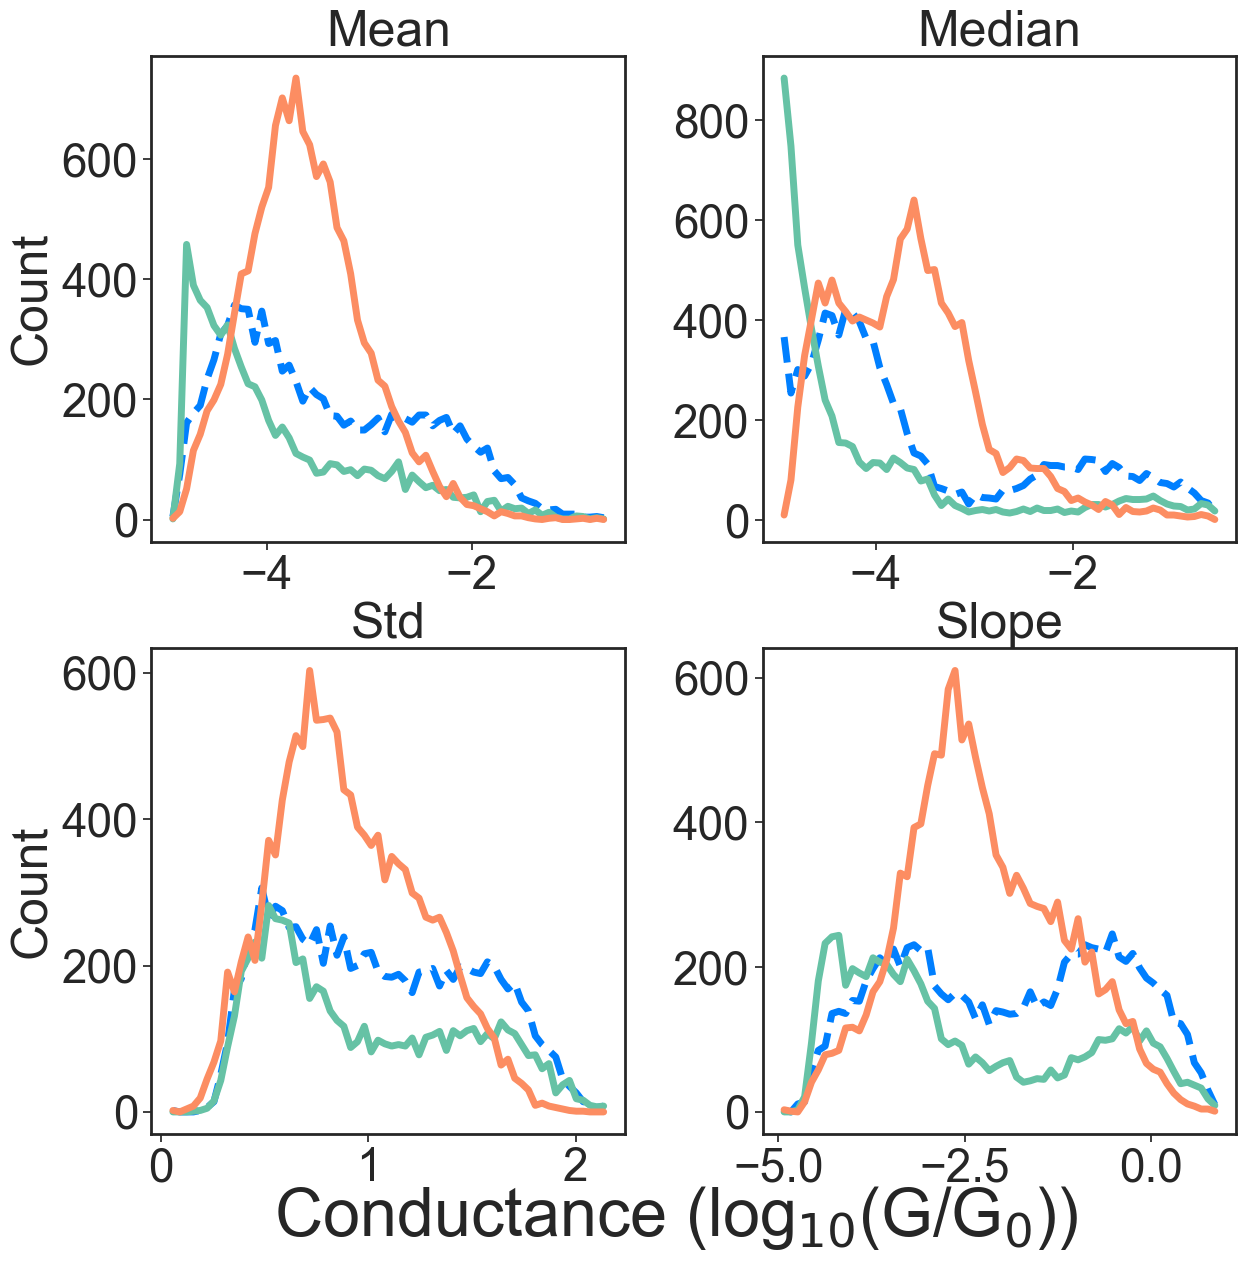

100%|██████████| 2989/2989 [00:00<00:00, 3302.74it/s]


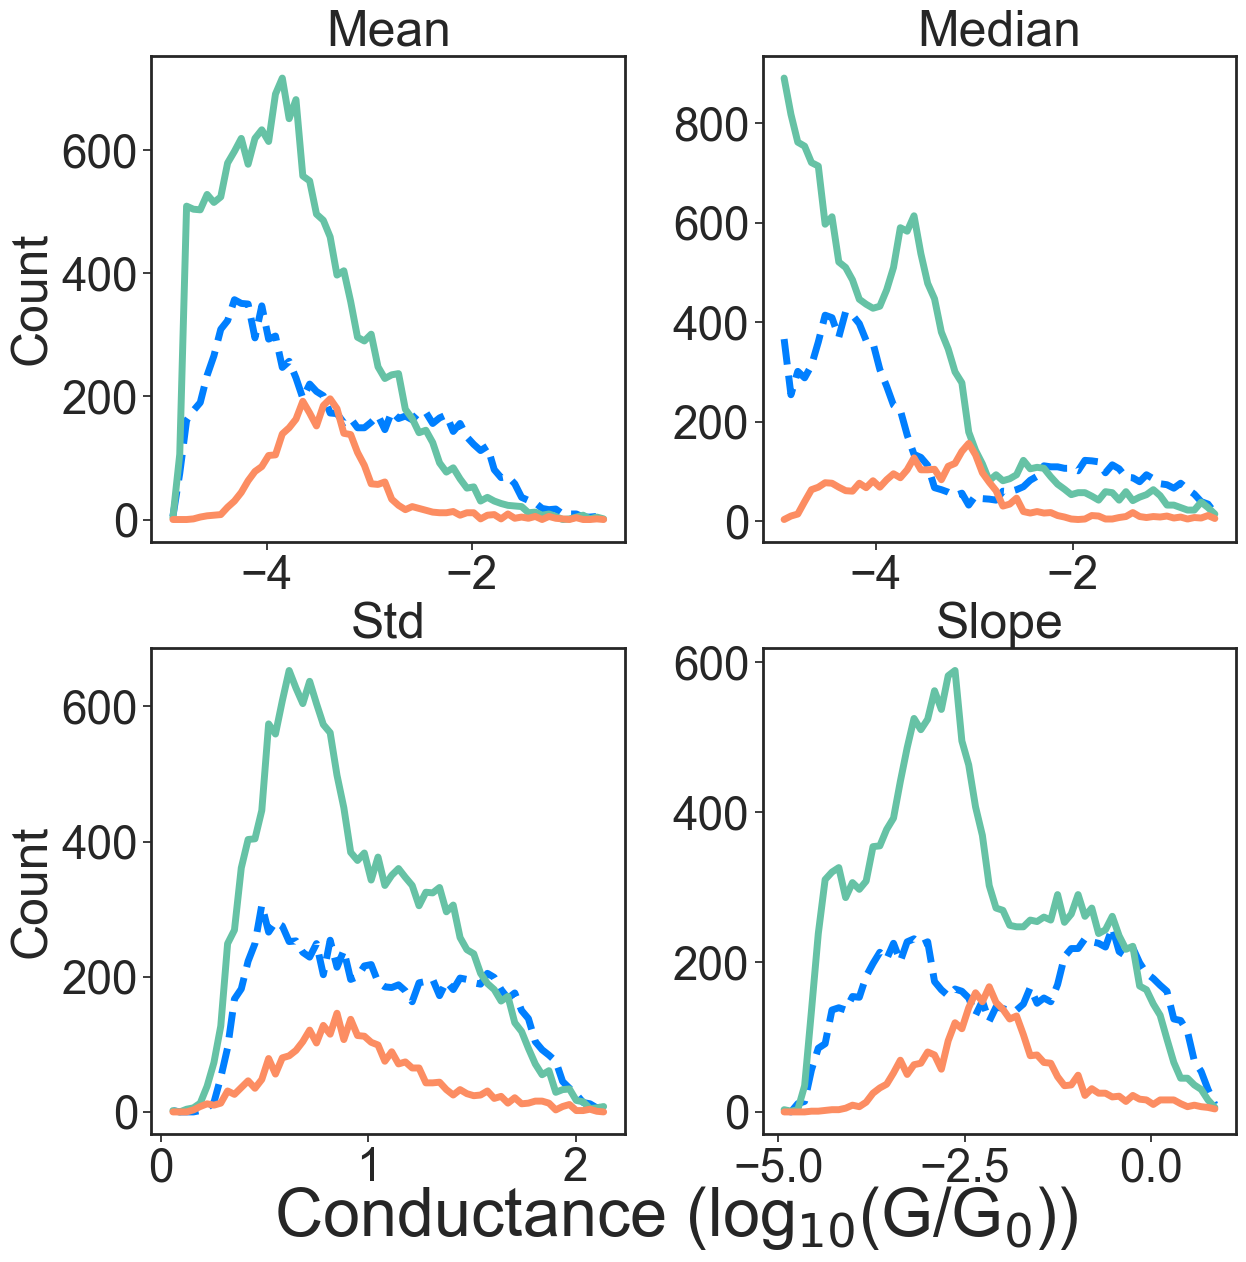

100%|██████████| 13089/13089 [00:03<00:00, 3315.37it/s]


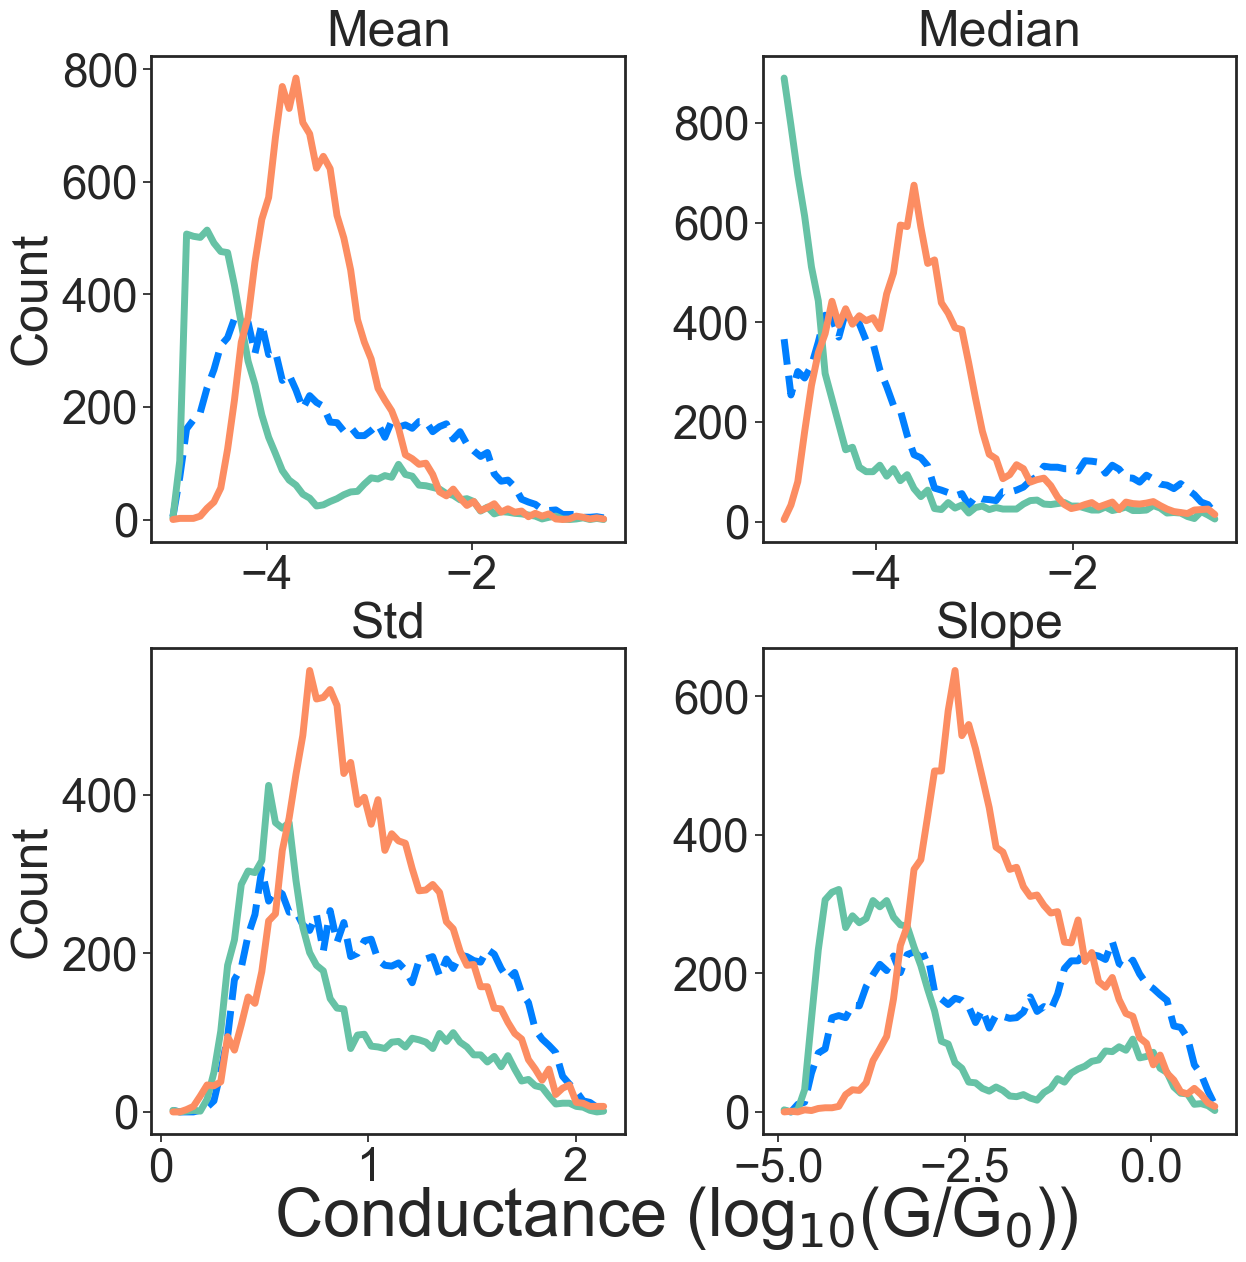

100%|██████████| 14237/14237 [00:04<00:00, 3197.07it/s]


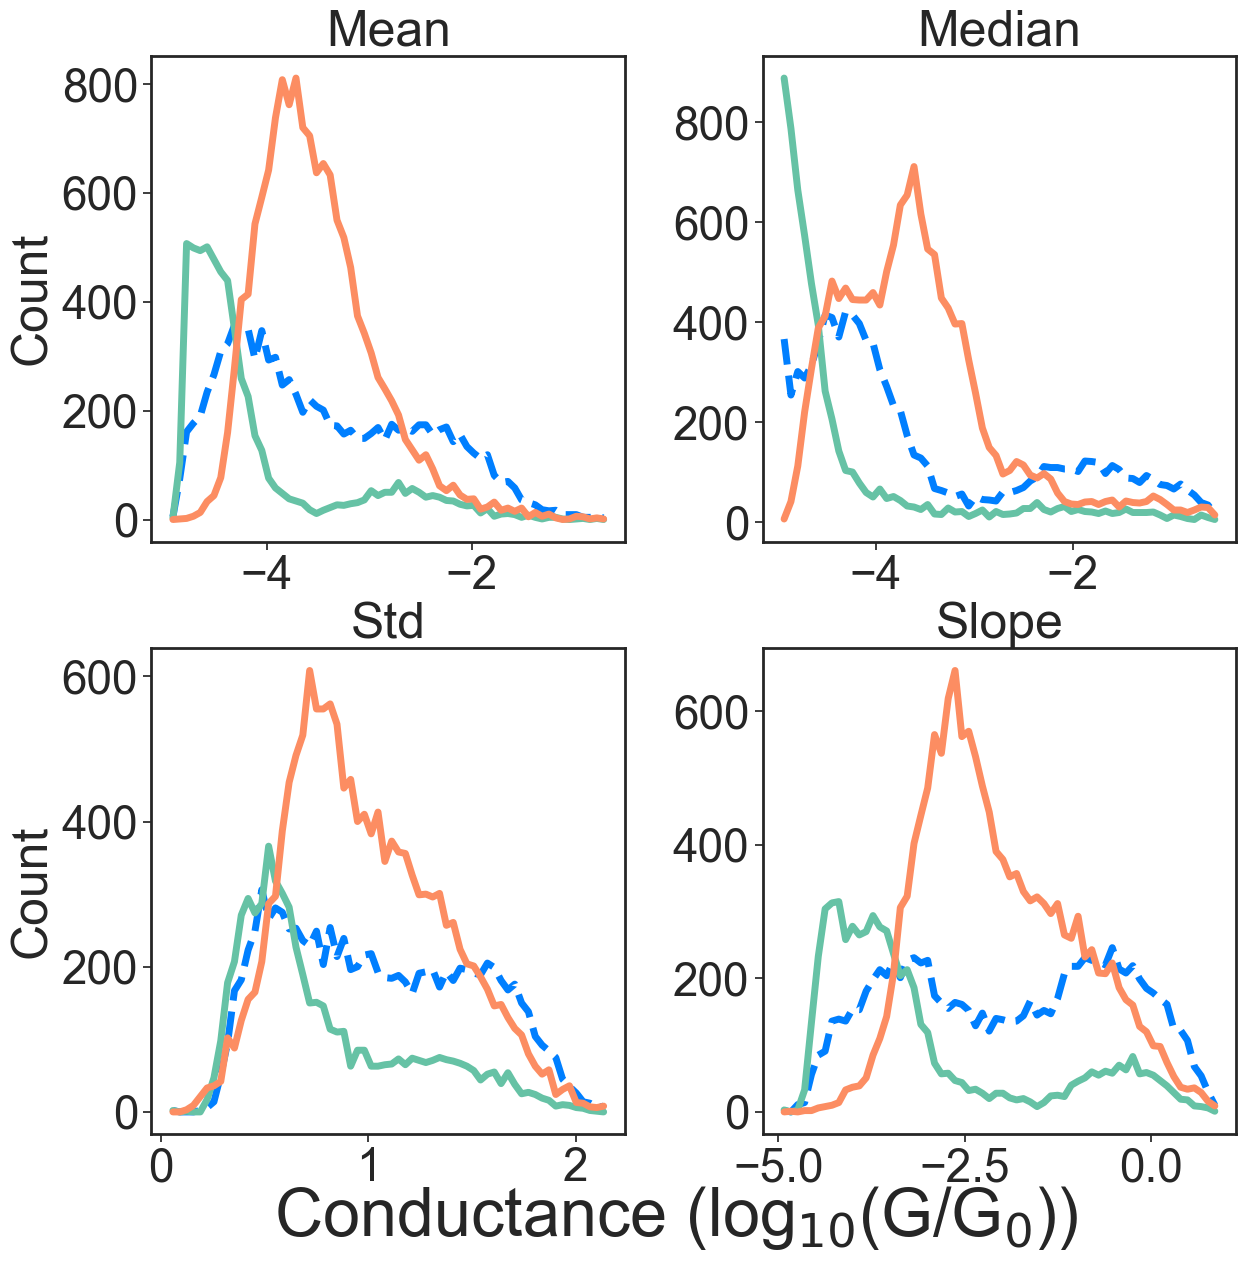

100%|██████████| 14402/14402 [00:04<00:00, 3561.57it/s]


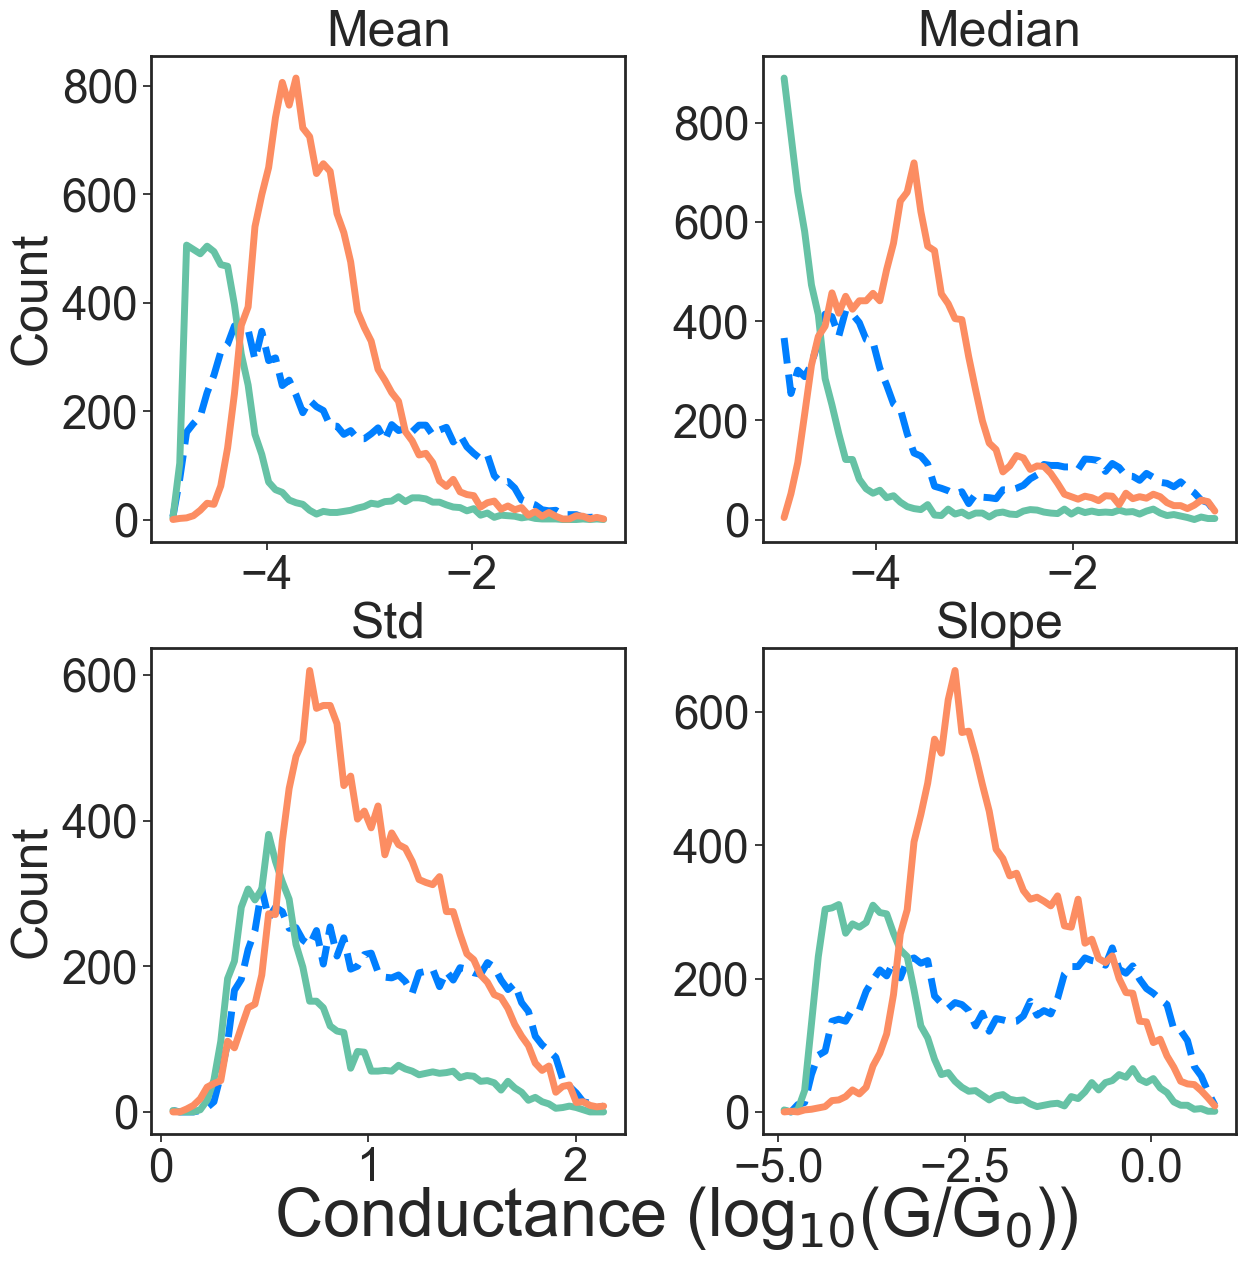

In [21]:
titles = [
    "Mean",
    "Median",
    "Std",
    "Slope",
]
summary_blanks = util_functions.summary_statistics(p_blanks)
for j, label_set in enumerate(predicted_labels):
    summary_pred_blanks = util_functions.summary_statistics(p_molecular[label_set == 1])
    summary_pred_not = util_functions.summary_statistics(p_molecular[label_set == -1])
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.ravel()
    for i, title in enumerate(titles):
        min_range = np.min(summary_blanks[:, i])
        max_range = np.max(summary_blanks[:, i])
        hist, binedges = np.histogram(summary_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Ref. blanks", linestyle="--", c=c[0])

        hist, binedges = np.histogram(summary_pred_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. blanks")

        hist, binedges = np.histogram(summary_pred_not[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. not-blanks")

        fs = 36
        if i % 2 == 0:
            axes[i].set_ylabel("Count", fontsize=fs)

        axes[i].set_title(title)
    fig.text(0.5, 0.05, CONDUCTANCE_LABEL, ha="center", va="center", fontsize=FONTSIZE)
    plt.subplots_adjust(hspace=.22, wspace=0.29)
    plt.savefig(f"summary_statistics_{j}.pdf")
    plt.show()

# Generate correlation plot

Amount of molecular hists: 13602


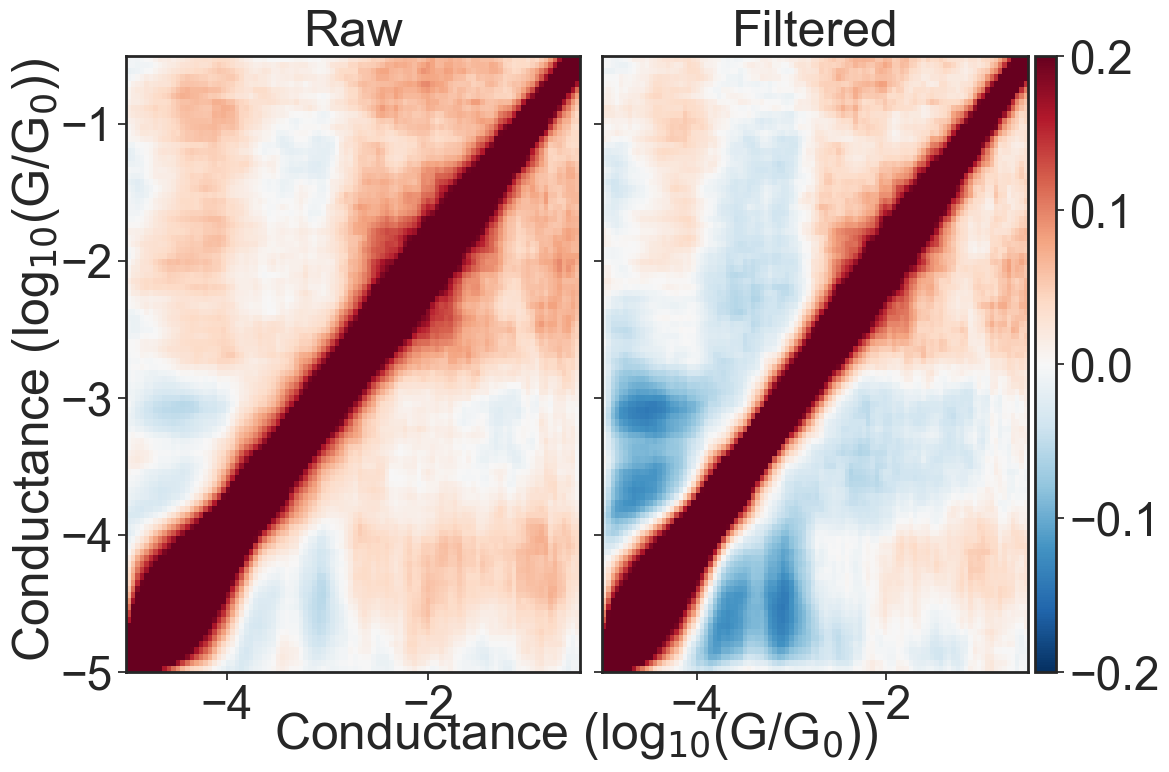

In [13]:
corr_wtun = np.corrcoef(plot_hist_molecular.T)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
vmax, vmin = 0.2, -0.2
im = axes[0].imshow(
    corr_wtun,
    vmin=vmin,
    vmax=vmax,
    extent=[
        pre_info.plot_low,
        pre_info.plot_high,
        pre_info.plot_low,
        pre_info.plot_high,
    ],
    aspect="auto",
    cmap="RdBu_r",
    origin="lower",
)
axes[0].set_title("Raw")

print(f"Amount of molecular hists: {len(hist_molecular[predicted_labels[1] == -1])}")
corr_wotun = np.corrcoef(plot_hist_molecular[predicted_labels[1] == -1].T)
im = axes[1].imshow(
    corr_wotun,
    vmin=vmin,
    vmax=vmax,
    extent=[
        pre_info.plot_low,
        pre_info.plot_high,
        pre_info.plot_low,
        pre_info.plot_high,
    ],
    aspect="auto",
    cmap="RdBu_r",
    origin="lower",
)
colorbar(im)
fig.text(
    0.5, 0.03, CONDUCTANCE_LABEL, va="center", ha="center", fontsize=FONTSIZE * 0.75
)
fig.text(
    0.05,
    0.5,
    CONDUCTANCE_LABEL,
    va="center",
    ha="center",
    fontsize=FONTSIZE * 0.75,
    rotation="vertical",
)
axes[1].set_title("Filtered")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig("./correlation.pdf")


## Clustering result

The following code block takes a long time to run and consumes a large amount of memory. We have provided a single set of labels from one of our production runs.

The first block generates the labels on the raw data set and the next one generates the labels for the filtered data set

In [14]:
# experiment = ClusteringExperiment(
#     raw_molecular=p_molecular[predicted_labels[-1] == -1],
#     default_molecular_hists=hist_molecular[predicted_labels[-1] == -1],
#     default_blank_hists=hist_blanks,
#     mea_bins=100,
#     rng_seed=RNG_STATE,
# )
# print("Generating feature sets..")
# experiment.generate_feature_sets(low=-5, high=-0.5)

# for n in np.arange(2, 7):
#     print("Instantiating models..")
#     cluster_models = experiment.instantiate_models(n_clusters=n)

#     fig, ax, cluster_labels = experiment.plot_clustering_results(
#         cluster_models=cluster_models, plt_low=-5, plt_high=-0.5
#     )
#     np.save(f"./cluster_labels_data_{n}.npy", cluster_labels)
#     fig.savefig(f"./clustering_data{n}.png")

In [15]:
# experiment = ClusteringExperiment(
#     raw_molecular=p_molecular,
#     default_molecular_hists=hist_molecular,
#     default_blank_hists=hist_blanks,
#     mea_bins=100,
#     rng_seed=RNG_STATE,
# )
# print("Generating feature sets..")
# experiment.generate_feature_sets(low=-5, high=-0.5)

# for n in np.arange(2, 7):
#     print("Instantiating models..")
#     cluster_models = experiment.instantiate_models(n_clusters=n)

#     fig, ax, cluster_labels = experiment.plot_clustering_results(
#         cluster_models=cluster_models, plt_low=-5, plt_high=-0.5
#     )
#     np.save(f"./cluster_labels_filtered_data_{n}.npy", cluster_labels)
#     fig.savefig(f"./clustering_filtered_data{n}.png")

In [16]:
cluster_labels = np.load("./cluster_labels_data_5.npy")
cluster_filtered_labels = np.load("./cluster_labels_filtered_data_5.npy")
oc_labels = np.load("./traditional_oc_labels_halftunneling.npy")

In [17]:
def plot_cluster(sample_hists, blank_hists, labels, axes):
    max_ax1 = 0
    for idx, (m, ax) in enumerate(
        tqdm(
            zip(
                np.arange(len(labels)), axes.ravel()
            ),
            total=len(axes.ravel())
        )
    ):      
    
        ax.plot(
            ax1_yaxis,
            blank_hists.sum(axis=0),
            c=c[0],
            linestyle="--",
            label="Ref. blanks" if idx == 0 else "",
            alpha=0.8,
        )
        ax.plot(
            ax1_yaxis,
            sample_hists.sum(axis=0),
            c="k",
            linestyle="--",
            label="Ref. samples" if idx == 0 else "",
            alpha=0.8,
        )

        for label in np.unique(labels[m]):
            pred = sample_hists[labels[m] == label]
            ax.plot(
                ax1_yaxis,
                pred.sum(axis=0),
                label=f"{label + 1}" if idx == 0 else "",
            )
            # print(f"Amount of traces in {label + 1}: {len(pred)}")

            if np.max(pred.sum(axis=0)) > max_ax1:
                max_ax1 = np.max(pred.sum(axis=0))


        if np.max(sample_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(sample_hists.sum(axis=0))

        if np.max(blank_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(blank_hists.sum(axis=0))

        ax.set_xlim(pre_info.plot_low, pre_info.plot_high)

100%|██████████| 5/5 [00:00<00:00, 71.75it/s]


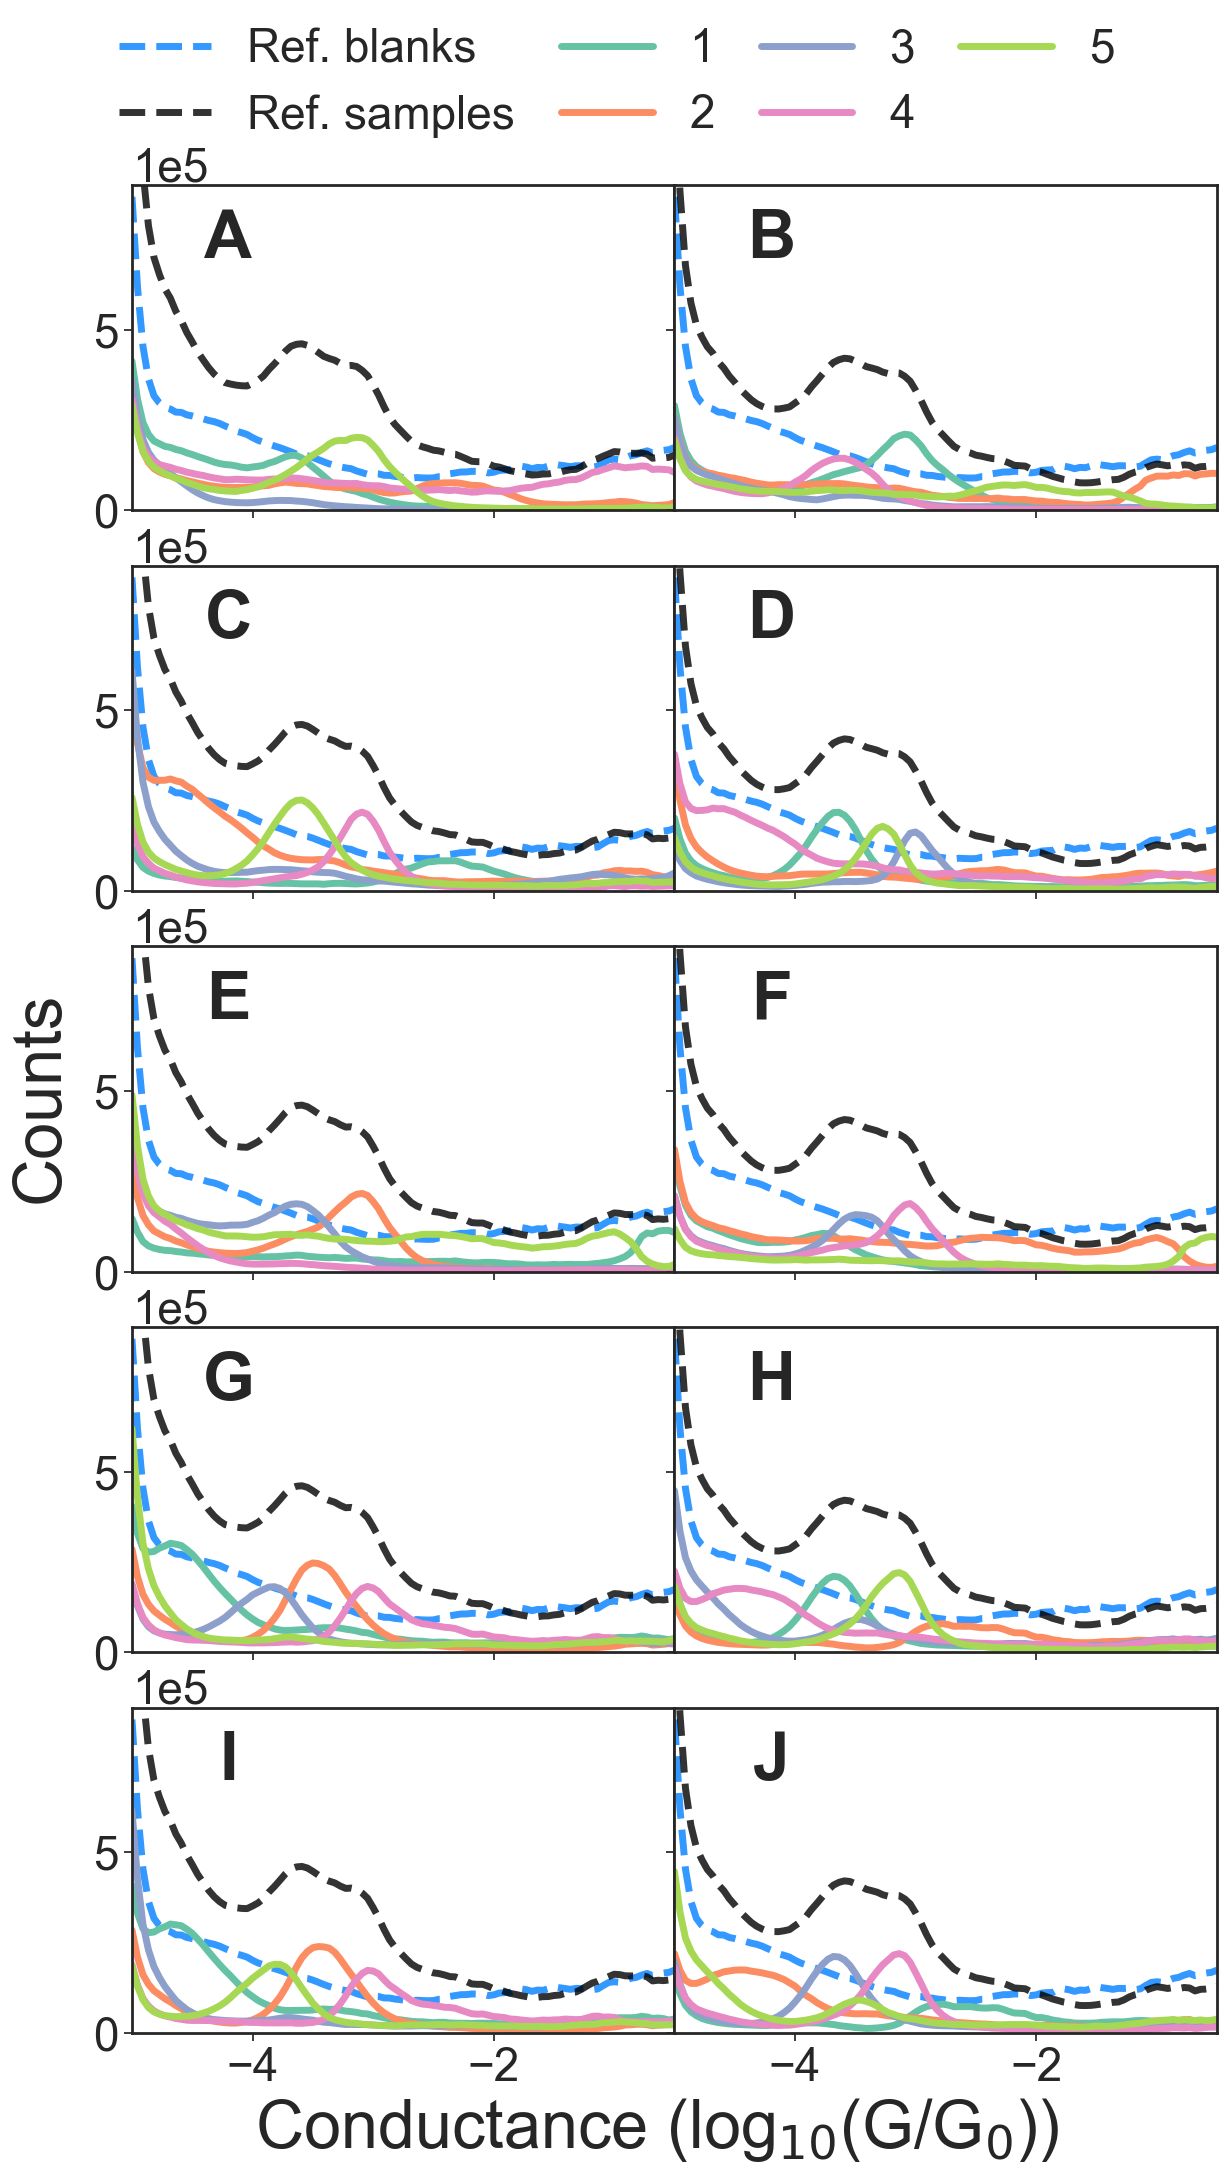

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(14, 24))
fig.subplots_adjust(hspace=0.17, wspace=0.0)
ax1_yaxis = np.linspace(
    pre_info.plot_low, pre_info.plot_high, plot_hist_molecular.shape[1]
)
plot_cluster(plot_hist_molecular, plot_hist_blanks, cluster_labels, axes[:, 0])
plot_cluster(
    plot_hist_molecular[oc_labels[5] == -1],
    plot_hist_blanks,
    cluster_filtered_labels,
    axes[:, 1],
)

for idx, ax in enumerate(axes.ravel()):
    ax.text(
        -4.2,
        7.5e5,
        ALPHABET[idx],
        va="center",
        ha="center",
        weight="bold",
        fontsize=FONTSIZE
    )
    ax.set_ylim(0, 9e5)
    ax.ticklabel_format(axis="y", scilimits=[-5, 4])

fig.text(
    0.06,
    0.5,
    "Counts",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=FONTSIZE,
)
fig.text(0.5, 0.07, CONDUCTANCE_LABEL, va="center", ha="center", fontsize=FONTSIZE)
axes.ravel()[0].legend(
    frameon=False,
    loc="lower left",
    bbox_to_anchor=(-0.1, 1.02, 1, 0),
    ncol=4,
    columnspacing=1.0,
)
plt.savefig("./clustering_result.pdf")
plt.show()

## Plot length distribution

In [19]:
length_range = (0, 2048*3 - 512)
length_bins = 128

100%|██████████| 6/6 [00:00<00:00, 112.79it/s]


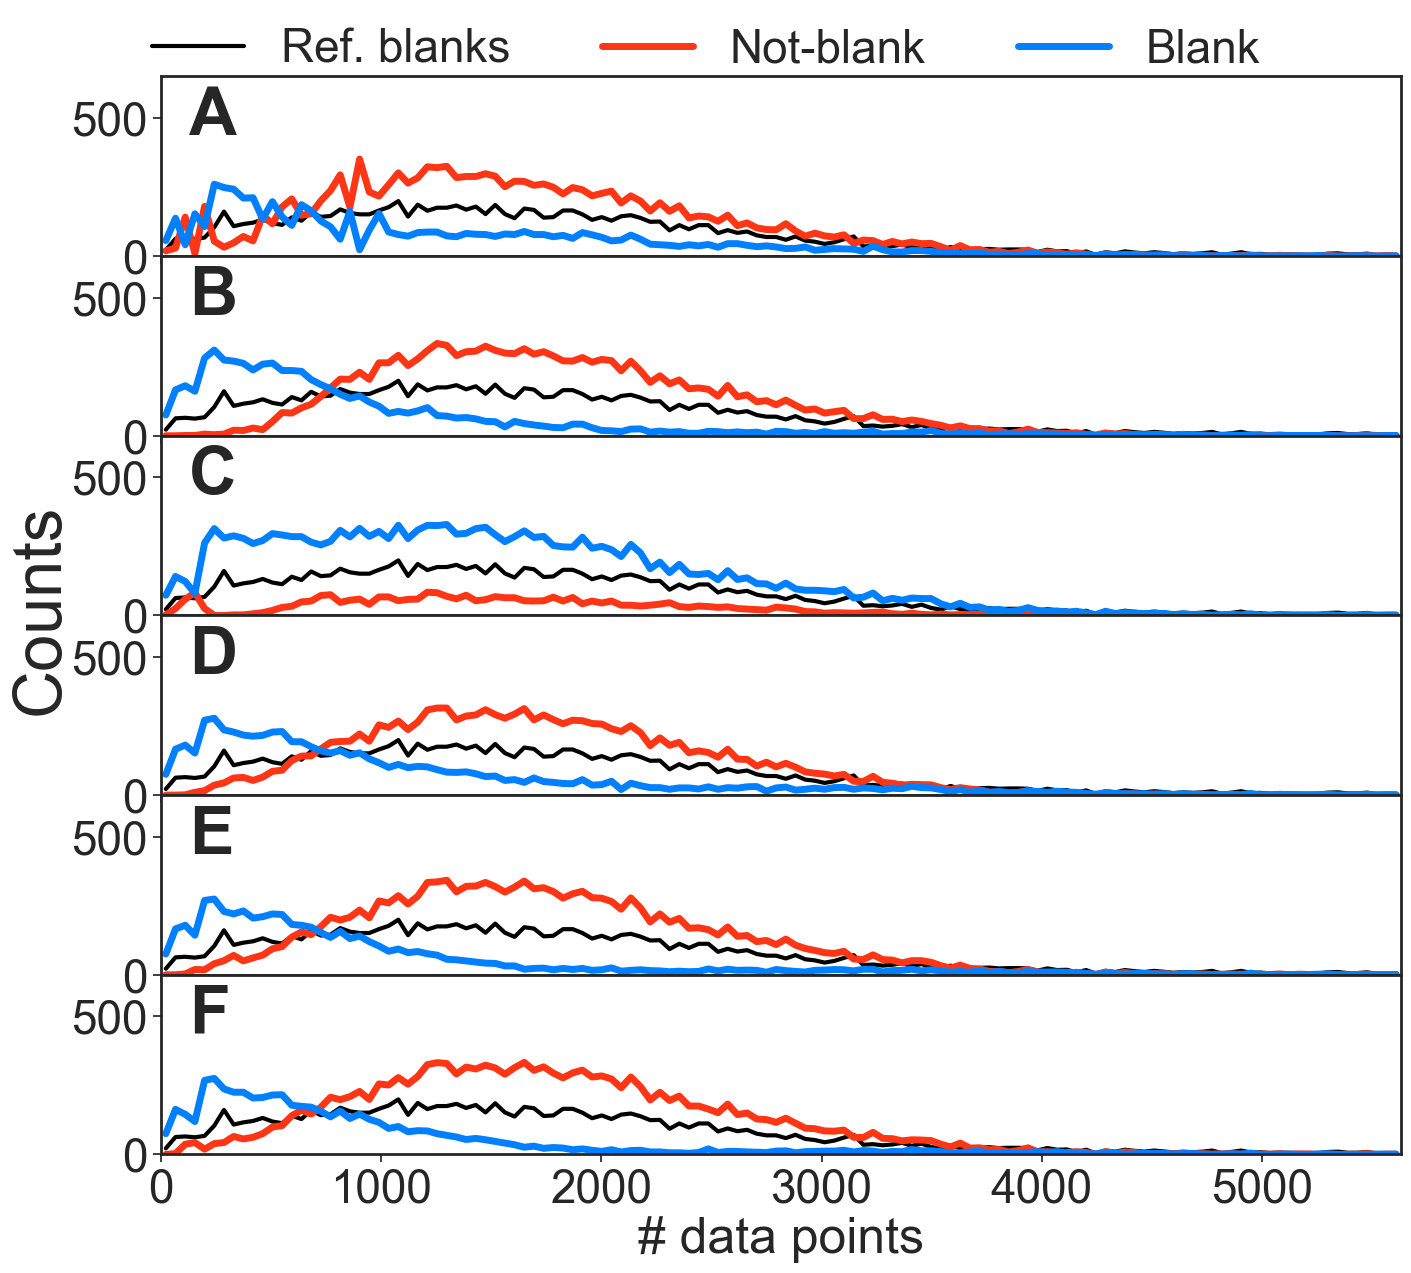

In [20]:
fig, ax = plt.subplots(len(models), 1, figsize=(16, 14), sharex=True, sharey=True)
pal = sns.color_palette("Set2", 12)
len_ref = np.histogram([len(x) for x in p_blanks], bins=length_bins, range=length_range)[0]
for idx, label_set in enumerate(tqdm(predicted_labels)):
    len_mol, binedges = np.histogram([len(x) for x in p_molecular[label_set == -1]], bins=length_bins, range=length_range)
    len_tun = np.histogram([len(x) for x in p_molecular[label_set == 1]], bins=length_bins, range=length_range)[0]

    binedges = (binedges[1:] + binedges[:-1])/2
    ax[idx].plot(binedges, len_ref, label="Ref. blanks", c="k", lw=3)
    ax[idx].plot(binedges, len_mol, label="Not-blank", c=c[1])
    ax[idx].plot(binedges, len_tun, label="Blank", c=c[0])
    ax[idx].text(128, 440, ALPHABET[idx], fontsize=FONTSIZE, weight="bold")
ax[0].legend(frameon=False, ncol=3, bbox_to_anchor=[1, 1, -0.08, 0.5])
plt.xlim(length_range)
plt.ylim(0, 650)
plt.xlabel("# data points")
fig.text(0.05, 0.5, "Counts", va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)

fig.subplots_adjust(hspace=0.0)
fig.savefig("length_distributions.pdf")
plt.show()  